In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=14, micro=2, releaselevel='final', serial=0)
matplotlib 3.10.8
numpy 2.4.1
pandas 3.0.0
sklearn 1.8.0
torch 2.10.0+cu130
cuda:0


In [26]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [27]:
from torchvision.transforms import Normalize

# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds: # 遍历每张图片,img.shape=[1,28,28]
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std


print(cal_mean_std(train_ds))
# 0.2860， 0.3205
transforms = nn.Sequential(
    Normalize([0.2860], [0.3205]) # 这里的均值和标准差是通过train_ds计算得到的
)

(tensor([0.2860]), tensor([0.3205]))


In [28]:
import torch
from torch import nn
import numpy as np

class NeuralNetwork(nn.Module):
    def __init__(self, layers_num=2):
        super().__init__()
        self.flatten = nn.Flatten()

        # --- 1. 定义初始网络结构 ---
        # 你修改的部分：先从 784 -> 300，再从 300 -> 100
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 300),
            nn.SELU(),
            nn.AlphaDropout(p=0.1), # 添加 AlphaDropout
            nn.Linear(300, 100),
            nn.SELU(),
            nn.AlphaDropout(p=0.1), # 添加 AlphaDropout
        )

        # --- 2. 循环添加中间层 ---
        # 根据 layers_num 动态增加 100 -> 100 的层
        for i in range(1, layers_num):
            self.linear_relu_stack.add_module(f"Linear_{i}", nn.Linear(100, 100))
            # 建议给 relu 也加上 i 编号，方便查看模型结构
            self.linear_relu_stack.add_module(f"selu_{i}", nn.SELU())
            self.linear_relu_stack.add_module(f"dropout_{i}", nn.AlphaDropout(p=0.1)) # 添加 AlphaDropout

        # --- 3. 输出层 ---
        # 最终输出 10 类
        self.linear_relu_stack.add_module("Output Layer", nn.Linear(100, 10))

        # --- 4. 初始化权重 ---
        self.init_weights()

    # ★★★ 必须加上 forward 函数 ★★★
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层的权重 W"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                # ★ 注意：这里必须用 zeros_ (带下划线)，表示原地修改
                nn.init.zeros_(m.bias)

# ---------------------------------------------------------
# 测试代码：确保能够成功运行
# ---------------------------------------------------------

# 1. 实例化模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork(layers_num=5).to(device) # 比如这里设 layers_num=5

# 2. 打印模型结构查看是否符合预期
print(model)

# 3. 重新定义优化器 (这一步很关键，每次改模型都要重置优化器)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print("\n✅ 模型定义成功，可以继续训练了！")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): SELU()
    (2): AlphaDropout(p=0.1, inplace=False)
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): SELU()
    (5): AlphaDropout(p=0.1, inplace=False)
    (Linear_1): Linear(in_features=100, out_features=100, bias=True)
    (selu_1): SELU()
    (dropout_1): AlphaDropout(p=0.1, inplace=False)
    (Linear_2): Linear(in_features=100, out_features=100, bias=True)
    (selu_2): SELU()
    (dropout_2): AlphaDropout(p=0.1, inplace=False)
    (Linear_3): Linear(in_features=100, out_features=100, bias=True)
    (selu_3): SELU()
    (dropout_3): AlphaDropout(p=0.1, inplace=False)
    (Linear_4): Linear(in_features=100, out_features=100, bias=True)
    (selu_4): SELU()
    (dropout_4): AlphaDropout(p=0.1, inplace=False)
    (Output Layer): Linear(in_features=100, out_features=10, bias=True)
  )
)

✅ 模型定义成功，可以继续

In [29]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# 假设 device 已经在外部定义，例如: device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@torch.no_grad()  # 装饰器：在验证阶段不计算梯度，节省显存并加速
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []

    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)

        # 前向计算
        logits = model(datas)

        # 计算验证集损失
        loss = loss_fct(logits, labels)
        loss_list.append(loss.item())

        # 验证集预测
        # argmax(axis=-1) 获取概率最大的类别索引
        preds = logits.argmax(axis=-1)

        # 将预测结果和真实标签转为 list，存入列表以便后续计算 sklearn 指标
        # 注意：需要先转回 cpu 再转 numpy
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    # 使用 sklearn 计算准确率
    acc = accuracy_score(label_list, pred_list)

    # 返回平均损失和准确率
    return np.mean(loss_list), acc

In [30]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [31]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1
    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)
        return logits

    @property
    def early_stop(self):
        return self.counter >= self.patience


In [32]:
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


epoch = 100

model = NeuralNetwork(layers_num=20)


In [33]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# 2. save best
save_ckpt_callback = SaveCheckpointsCallback("checkpoints", save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10, min_delta=0.001)

model = model.to(device)

In [34]:
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
    )

  0%|          | 0/375000 [00:00<?, ?it/s]

Early stop at epoch 28 / global_step 105000


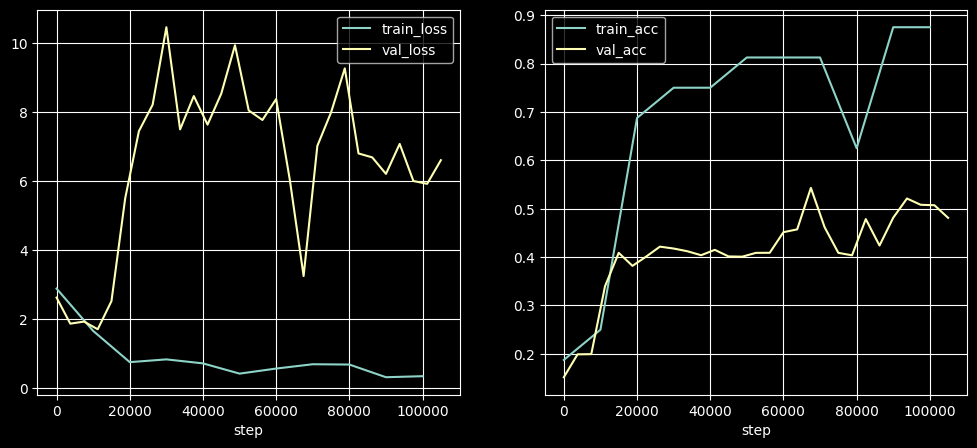

In [35]:
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(6 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xlabel("step")

    plt.show()

plot_learning_curves(record, sample_step=10000)  #横坐标是 steps

In [ ]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

这里之前设置0.2及以上的p是0.15的准确率，alphadropout对参数设置非常敏感